In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pyRothC.RothC import RothC
np.set_printoptions(precision=3,suppress=True )

## RothC 

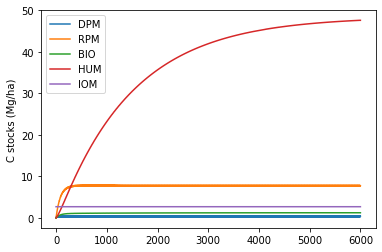

In [4]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
Cinputs=2.7   #Annual C inputs to soil in Mg/ha/yr


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=Cinputs,
             pE=1.0,
             C0=np.array([0, 0, 0, 0, 2.7]))

df = rothC.compute()

fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
plt.show()



## End